# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/remi421/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 75 (delta 9), reused 7 (delta 7), pack-reused 58 (from 2)
Receiving objects: 100% (75/75), 2.41 MiB | 4.55 MiB/s, done.
Resolving deltas: 100% (21/21), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


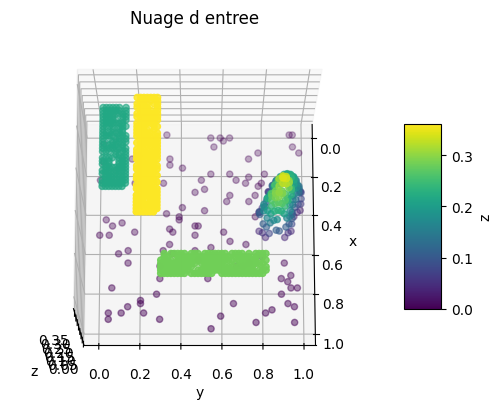

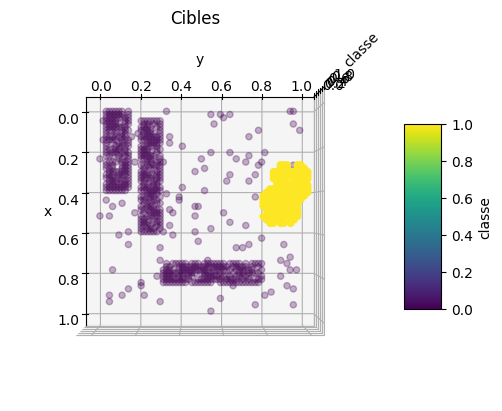

1


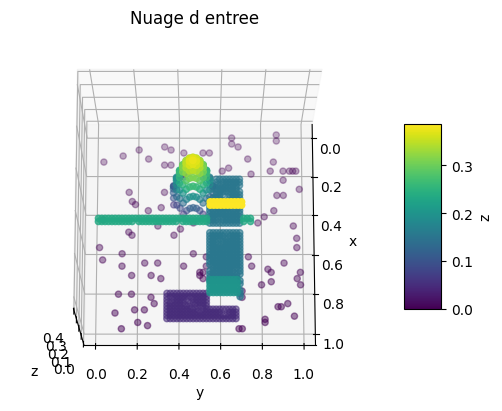

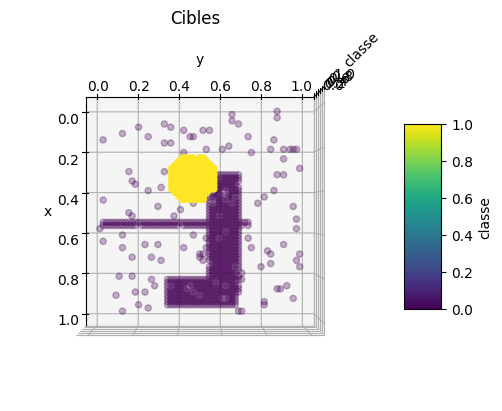

2


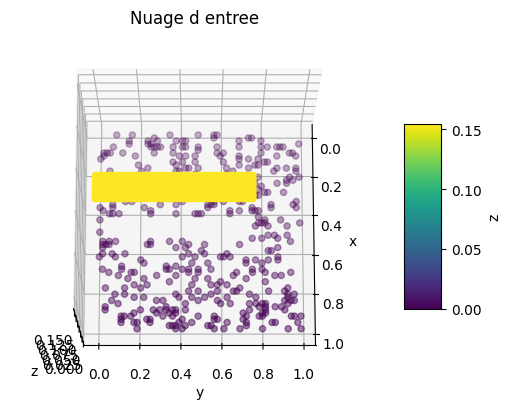

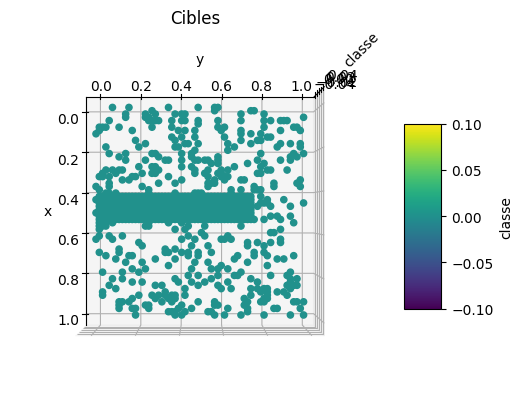

3


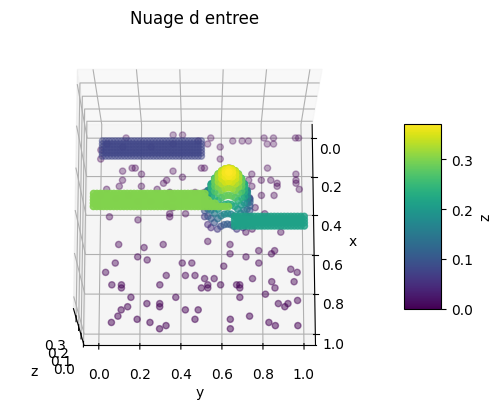

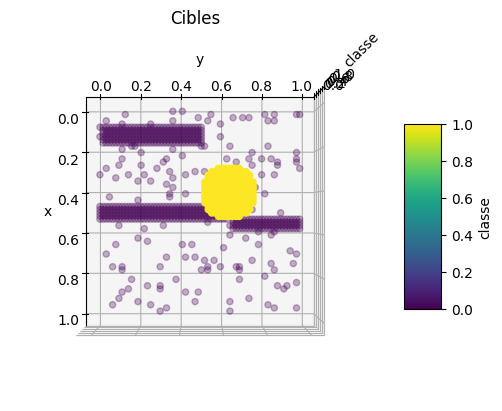

4


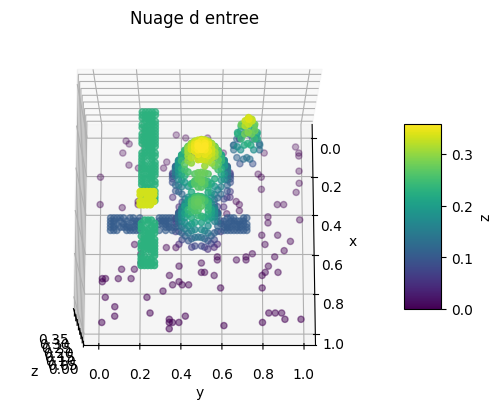

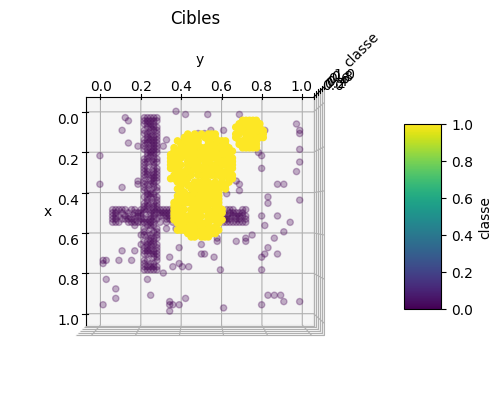

5


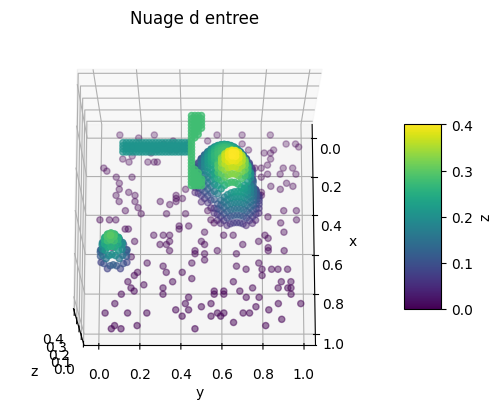

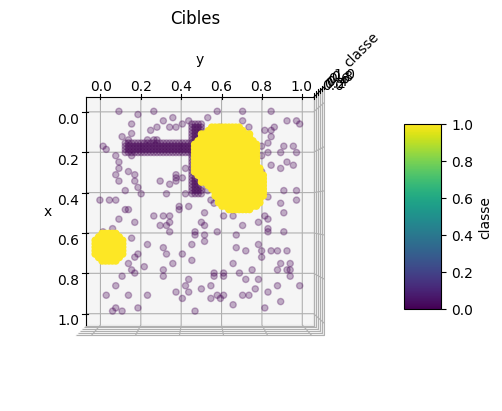

In [2]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [4]:
print(input_points.size())

torch.Size([6, 3, 800])


La première dimension correspond au batch_size (qui vaut 6)

La seconde correspond aux coordonnées de chaque point (x,y,z)

La dernière correspond au nombre de points dans le nuage de points. (ici 800)

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Non , ils ne sont pas rangés dans un ordre particulier.
Ils sont échantillonnés aléatoirement sur la surface des objets simulés (immeubles et igloos).

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Il faudrait transformer les données 3D en une représentation 2D. Projeter le nuage de points pour créer des images de profondeur est une solution. (on peut ensuite utiliser cette projection en entrée du FCN ou du viT)

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [5]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

In [6]:
print(output.size())

torch.Size([6, 800, 2])


La dimension 0 correspond à la taille du batch.

La seconde (800) correspond au nombre de points dans le nuage de points

La troisième dimension (2) correspond au nombre de classes pour la segmentation (sols/toits des bâtiments , igloos)

Pour justifier l'invariance des points , en citant l'article :" In this paper, we design a
novel type of neural network that directly consumes point
clouds, which well respects the permutation invariance of
points in the input."

In [7]:
import torch

# Générer une permutation aléatoire des indices
idx = torch.randperm(input_points.size(1))

# Appliquer la permutation à input_points
permuted_input = input_points[:, idx, :]

# Passer les données permutées au modèle
output_permuted, _, _ = pointnet(permuted_input)

# Comparer output et output_permuted
# (par exemple, en calculant la différence absolue moyenne)
diff = torch.mean(torch.abs(output - output_permuted))
print(diff)

tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

Les opérations conduisant à une segmentation sont : mlp (64, 64, 128, 1024) , max pool , mlp(512,256,128) et mlp(128,m).


Le terme "shared signifie que les couches MLP sont appliquées de la même manière à tous les points du nuage (ie les mêmes poids et biais sont utilisés pour tous les points, ce qui permet au modèle de traiter les points de manière indépendante et parallèle)

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [10]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = torch.nn.CrossEntropyLoss().cuda()


In [12]:
import torch
import torch.nn as nn
from utils_probleme2 import gen_pointcloud, plot_triplets, PointNetSegHead

# Définir le modèle
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()  # Assurez-vous qu'il est sur le bon appareil (GPU si disponible)

# Définir l'optimiseur
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Instancier la fonction de perte CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss().cuda()  # Assurez-vous qu'elle est sur le bon appareil (GPU si disponible)

# Paramètres d'entraînement
batch_size = 64
n_epochs = 20 # j ai diminué le nombre d epoques pour gagner du temps
n_batch_per_epoch = 10

# Boucle d'entraînement
for epoch in range(1, n_epochs + 1):
    print(f"Epoch : {epoch}")
    for batch in range(1, n_batch_per_epoch + 1):
        # Générer un batch de données
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Faire une prédiction
        outputs, _, _ = pointnet(input_points)

        # Calculer la perte avec CrossEntropyLoss
        loss = loss_fn(outputs.transpose(1, 2), target_list)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

    # Calculer la justesse sur un batch de validation (facultatif)
    with torch.no_grad():
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        outputs, _, _ = pointnet(input_points)

        preds = outputs.transpose(1, 2).max(1)[1]
        accuracy = (preds == target_list).float().mean().item()

    print(f"Accuracy : {accuracy}")



Epoch : 1
Accuracy : 0.4582226574420929
Epoch : 2
Accuracy : 0.46263670921325684
Epoch : 3
Accuracy : 0.48435544967651367
Epoch : 4
Accuracy : 0.4608398377895355
Epoch : 5
Accuracy : 0.4344726502895355
Epoch : 6
Accuracy : 0.4659179449081421
Epoch : 7
Accuracy : 0.47603514790534973
Epoch : 8
Accuracy : 0.45849609375
Epoch : 9
Accuracy : 0.459296852350235
Epoch : 10
Accuracy : 0.45070311427116394
Epoch : 11
Accuracy : 0.47164061665534973
Epoch : 12
Accuracy : 0.49253904819488525
Epoch : 13
Accuracy : 0.48445311188697815
Epoch : 14
Accuracy : 0.5355663895606995
Epoch : 15
Accuracy : 0.45548826456069946
Epoch : 16
Accuracy : 0.528124988079071
Epoch : 17
Accuracy : 0.46210935711860657
Epoch : 18
Accuracy : 0.489082008600235
Epoch : 19
Accuracy : 0.5364453196525574
Epoch : 20
Accuracy : 0.5070507526397705


In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
